# Segmentation and Feature Detection

Kevin J. Walchko
created 17 Aug 2017

---

blah ...


## References

- [Official OpenCV python tutorials](http://docs.opencv.org/3.1.0/db/d27/tutorial_py_table_of_contents_feature2d.html)
- [Image Segmentation](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html#watershed)
- [Learn OpenCV homography](https://www.learnopencv.com/homography-examples-using-opencv-python-c/)

## Setup

In [1]:
%matplotlib inline 

from __future__ import print_function
from __future__ import division
import cv2         # opencv itself
import numpy as np # matrix manipulations

from matplotlib import pyplot as plt           # this lets you draw inline pictures in the notebooks
import pylab                                   # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

## Image Segmentation with Watershed Algorithm

Any grayscale image can be viewed as a topographic surface where high intensity denotes peaks and hills while low intensity denotes valleys. You start filling every isolated valleys (local minima) with different colored water (labels). As the water rises, depending on the peaks (gradients) nearby, water from different valleys, obviously with different colors will start to merge. To avoid that, you build barriers in the locations where water merges. You continue the work of filling water and building barriers until all the peaks are under water. Then the barriers you created gives you the segmentation result. This is the “philosophy” behind the watershed. You can visit the [CMM](http://cmm.ensmp.fr/~beucher/wtshed.html) webpage on watershed to understand it with the help of some animations.

But this approach gives you oversegmented result due to noise or any other irregularities in the image. So OpenCV implemented a marker-based watershed algorithm where you specify which are all valley points are to be merged and which are not. It is an interactive image segmentation. What we do is to give different labels for our object we know. Label the region which we are sure of being the foreground or object with one color (or intensity), label the region which we are sure of being background or non-object with another color and finally the region which we are not sure of anything, label it with 0. That is our marker. Then apply watershed algorithm. Then our marker will be updated with the labels we gave, and the boundaries of objects will have a value of -1.

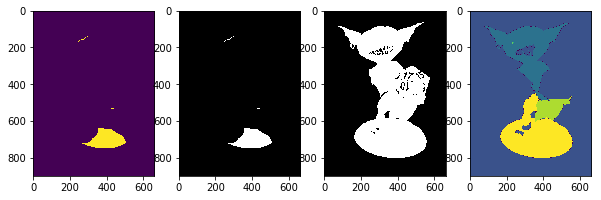

In [2]:
# img = cv2.imread('coins.jpg')
img = cv2.imread('dnd.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)


# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

# boundries are marked as -1
markers = cv2.watershed(img,markers)
# img[markers == -1] = [255,0,0]

plt.subplot(1,4,1)
plt.imshow(sure_fg)

plt.subplot(1,4,2)
plt.imshow(sure_fg, cmap='gray')

plt.subplot(1,4,3)
plt.imshow(thresh, cmap='gray')

plt.subplot(1,4,4)
plt.imshow(markers)

len(markers)==900


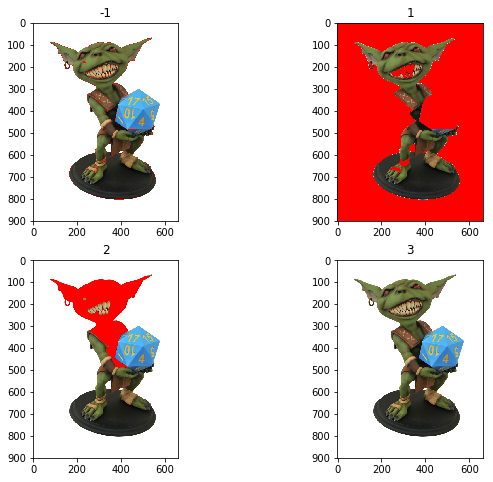

In [3]:
markers = cv2.watershed(img,markers)
print('len(markers)=={}'.format(len(markers)))
# img[markers == 1] = [255,0,0]

cimg = img.copy()
cimg[markers == -1] = [255,0,0]
plt.subplot(2,2,1)
plt.imshow(cimg)
plt.title(-1)

for i in range(1, 4):
    cimg = img.copy()
    cimg[markers == i] = [255,0,0]
    plt.subplot(2, 2, i+1)
    plt.imshow(cimg)
    plt.title(i)

# Feature Detection

Features are image locations that are "easy" to find in the future.  Indeed, one of the early feature detection techniques Lucas-Kanade, sometimes called Kanade-Lucas-Tomasi or KLT features come from a seminal paper called "Good features to track".

Edges find brightness discontinuities in an image, features find distinctive regions. There are a bunch of different feature detectors and these all have some characteristics in common: they should be quick to find, and things that are close in image-space are close in feature-space (that is, the feature representation of an object looks like the feature representation of objects that look like that object).

## Corner detectors
If you think of edges as being lines, then corners are an obvious choice for features as they represent the intersection of two lines. One of the earlier corner detectors was introduced by Harris, and it is still a very effective corner detector that gets used quite a lot: it's reliable and it's fast. 

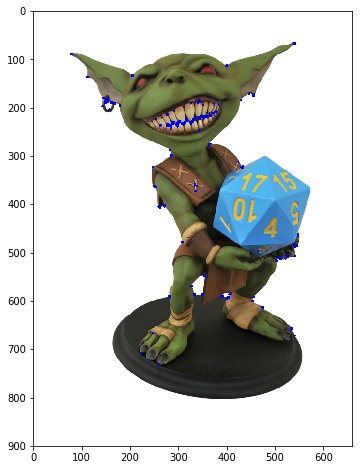

In [6]:
input_image = cv2.imread('dnd.jpg')
input_image = cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB)
harris_test=input_image.copy()
#greyscale it
gray = cv2.cvtColor(harris_test,cv2.COLOR_RGB2GRAY)

gray = np.float32(gray)
blocksize=4 # 
kernel_size=3 # sobel kernel: must be odd and fairly small

# run the harris corner detector
dst = cv2.cornerHarris(gray,blocksize,kernel_size,0.05) # parameters are blocksize, Sobel parameter and Harris threshold

#result is dilated for marking the corners, this is visualisation related and just makes them bigger
dst = cv2.dilate(dst,None)
#we then plot these on the input image for visualisation purposes, using bright red
harris_test[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(harris_test);

Properly speaking the Harris Corner detection is more like a Sobel operator - indeed it is very much like a sobel operator. It doesn't really return a set of features, instead it is a filter which gives a strong response on corner-like regions of the image. We can see this more clearly if we look at the Harris output from the cell above (dst is the Harris response, before thresholding). Well we can kind-of see. You should be able to see that there are slightly light places in the image where there are corner like features, and that there are really light parts of the image around the black and white corners of the writing 

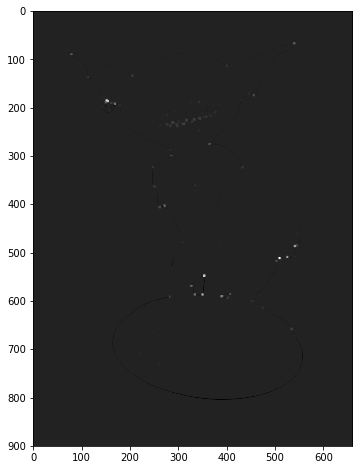

In [7]:
plt.imshow(dst,cmap = 'gray');

## Moving towards feature space

When we consider modern feature detectors there are a few things we need to mention. What makes a good feature includes the following: 

* Repeatability (got to be able to find it again)
* Distinctiveness/informativeness (features representing different things need to be different)
* Locality (they need to be local to the image feature and not, like, the whole image)
* Quantity (you need to be able to find enough of them for them to be properly useful)
* Accuracy (they need to accurately locate the image feature)
* Efficiency (they've got to be computable in reasonable time)

**Note:** some of the very famous feature detectors (SIFT/SURF and so on) are around, but aren't in OpenCV by default due to patent issues. You can build them for OpenCV if you want, or you can find other implementations (David Lowe's SIFT implementation works just fine). Just google for instructions.  For the purposes of this lesson (and to save time) we're only going to look at those which are actually in OpenCV.

number key points found: 500
point: (317.0, 225.0) size: 31.0 angle: 206.708602905


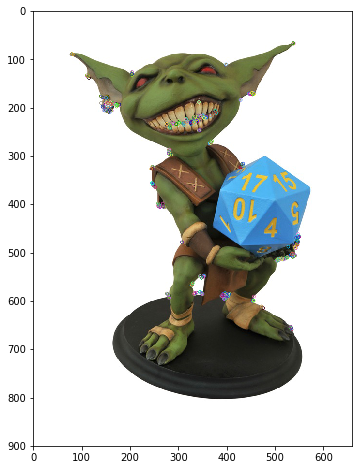

In [8]:
# make a copy to play with
orbimg=input_image.copy()

orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(orbimg,None)
# compute the descriptors with ORB
kp, des = orb.compute(orbimg, kp)
# draw keypoints
print('number key points found:', len(kp))
print('point: {} size: {} angle: {}'.format(kp[1].pt, kp[1].size, kp[1].angle))
cv2.drawKeypoints(orbimg,kp,orbimg)

plt.imshow(orbimg);

## Matching features
Finding features is one thing but actually we want to use them for matching. 
First let's get something where we know there's going to be a match

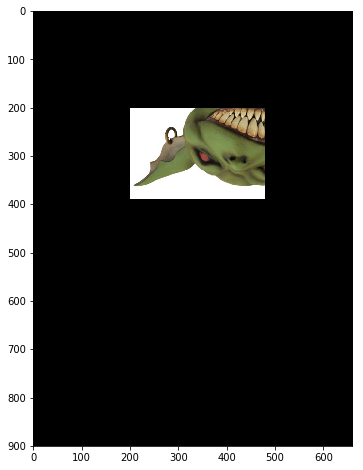

In [9]:
# create an image with all zeros (black), use the input image as a template for
# size and the color depth (3 for color)
img2match=np.zeros(input_image.shape,np.uint8)

# grab the goblin's face
face=input_image[60:250, 70:350] # copy out a bit
img2match[60:250,70:350]=[0,0,0] # blank that region
face=cv2.flip(face,0) # flip the copy
img2match[200:200+face.shape[0], 200:200+face.shape[1]]=face # paste it back somewhere else
plt.imshow(img2match);

## Matching keypoints

The feature matching function (in this case Orb) detects and then computes keypoint descriptors. These are a higher dimensional representation of the image region immediately around a point of interest (sometimes literally called "interest points"). 

These higher-dimensional representations can then be matched; the strength you gain from matching these descriptors rather than image regions directly is that they have a certain invariance to transformations (like rotation, or scaling). OpenCV providers matcher routines to do this, in which you can specify the distance measure to use.

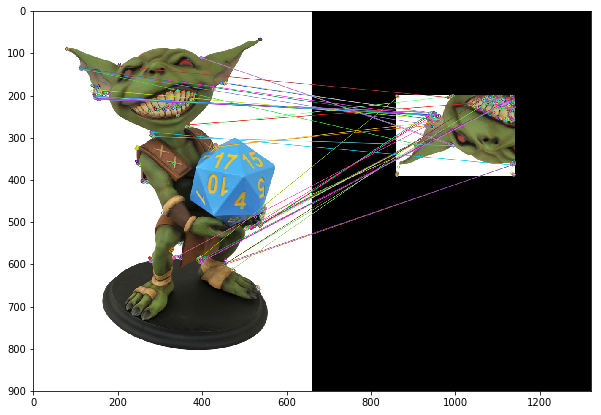

In [10]:
kp2 = orb.detect(img2match,None)
# compute the descriptors with ORB
kp2, des2 = orb.compute(img2match, kp2)
# create BFMatcher object: this is a Brute Force matching object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des,des2)
 
# Sort them by distance between matches in feature space - so the best matches are first.
matches = sorted(matches, key = lambda x:x.distance)
 
# Draw first 50 matches.
oimg = cv2.drawMatches(orbimg,kp,img2match,kp2,matches[:50], orbimg)
 
plt.imshow(oimg);

As you can see there are some false matches, but it's fairly clear that most of the matched keypoints found are actual matches between image regions on the face.

To be more precise about our matching we could choose to enforce **homography** constraints, which looks for features that sit on the same plane.

# Homography

A Homography is a transformation (a 3×3 matrix) that maps the points in one image to the corresponding points in the other image. Since we are dealing with 2d images, we do:

$$
\begin{bmatrix}
  x_1 \\
  y_1 \\
  1
\end{bmatrix} =
H_{3x3}
\begin{bmatrix}
  x_2 \\
  y_2 \\
  1
\end{bmatrix} \\
H_{3x3} = \begin{bmatrix}
  Rotation_{2x2} & Translation_{(x,y)} \\
  skew & 1 
\end{bmatrix}
$$

Notice the 1 at the bottom, hopefully this reminds of homogenious transforms back in block 1, forward kinematics, but in 2d instead of 3d.

To calculate a homography between two images, you need to know at least 4 point correspondences between the two images. If you have more than 4 corresponding points, it is even better. OpenCV will robustly estimate a homography that best fits all corresponding points. Usually, these point correspondences are found automatically by matching features like with SIFT or SURF between the images.

```python
'''
pts_src and pts_dst are numpy arrays of points
in source and destination images. We need at least 
4 corresponding points. 
'''
h, status = cv2.findHomography(pts_src, pts_dst)
 
''' 
The calculated homography can be used to warp 
the source image to destination. Size is the 
size (width,height) of im_dst
'''
 
im_dst = cv2.warpPerspective(im_src, h, size)
```

## Virtual Billboards

In many televised sports events, advertisement in virtually inserted in live video feed. E.g. in soccer and baseball the ads placed on small advertisement boards right outside the boundary of the field can be virtually changed. Instead of displaying the same ad to everybody, advertisers can choose which ads to show based on the person’s demographics, location etc. In these applications the four corners of the advertisement board are detected in the video which serve as the destination points. The four corners of the ad serve as the source points. A homography is calculated based on these four corresponding points and it is used to warp the ad into the video frame.

advert size: (403, 574, 3)
Homography matrix: [[  4.27796377e-01  -2.48138958e-01   1.00000000e+02]
 [  4.27796377e-01   2.35757002e-02   1.00000000e+02]
 [  1.26790175e-03  -1.12281629e-03   1.00000000e+00]]


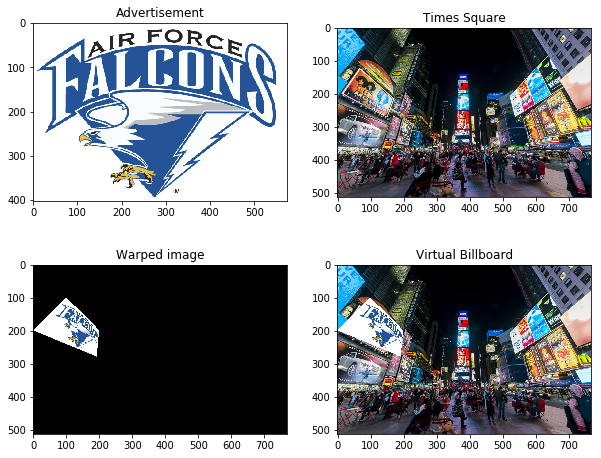

In [11]:
advert = cv2.imread('afa.jpg')
advert = cv2.cvtColor(advert,cv2.COLOR_BGR2RGB)

print('advert size:', advert.shape)

ts = cv2.imread('times-square.jpg')
ts = cv2.cvtColor(ts,cv2.COLOR_BGR2RGB)

# original image dimensions
pts_src = np.array([
    [0, 0],
    [0, advert.shape[0]],
    [advert.shape[0], advert.shape[1]],
    [advert.shape[1], 0]
])

# destination to map too
# note: I just eye balled this ... not perfect!
pts_dst = np.array([
    [100, 100],
    [0, 200],
    [150, 330],
    [200, 200]
])

h, status = cv2.findHomography(pts_src, pts_dst)

print('Homography matrix:', h)

# warp advert image
im_dst = cv2.warpPerspective(advert, h, (ts.shape[1], ts.shape[0]))

# this section of code will create a mask, then replace the masked 
# area with our advert:
# 1. convert copy to grayscale
# 2. threshold image so it is just black and white (binary)
# 3. invert mask (black)
# 4. cut out existing current colors there, anything and'ed with 0 is 0
# 5. now add the two images together and fill in the cut out
img2gray = cv2.cvtColor(im_dst,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)
img1_bg = cv2.bitwise_and(ts,ts,mask = mask_inv)
final = img1_bg + im_dst

plt.subplot(2,2,1)
plt.imshow(advert)
plt.title('Advertisement')

plt.subplot(2,2,2)
plt.imshow(ts)
plt.title('Times Square')

plt.subplot(2,2,3)
plt.imshow(im_dst)
plt.title('Warped image')

plt.subplot(2,2,4)
plt.imshow(final)
plt.title('Virtual Billboard');

Notice in the bottom picture of times square, we are able to insert the advertisement onto the billboard by warping the image. With a little more programming and finess, you could start your own business selling advertisements to people on virtual billboards.


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

# Color Quantinization

Reducing the number of colors in an image can be useful. Image you are trying to detect and maybe track the color red. Unfortunately there are a lot of different RGB (or HSV or whatever) numerical discriptions for what someone would call red. Sometimes it is nice to reduce all of those possible values down to just a few and then try to detect one of those colors. 

Unfortunately this is a little slow because of kmeans. :(

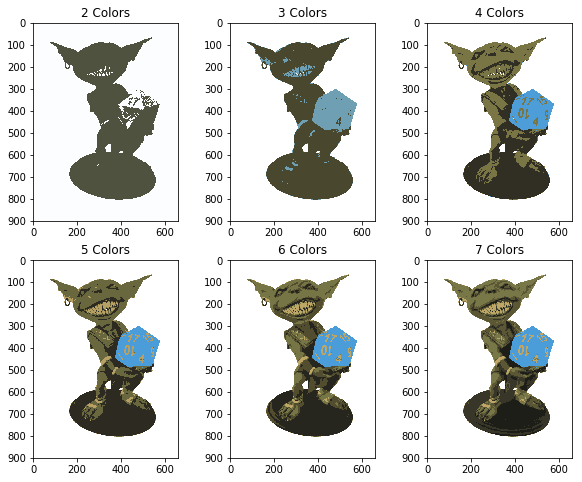

In [4]:
def quantize(img, K):
    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    return res2

img = cv2.imread('dnd.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for k in range(2,8):
    qimg = quantize(img, k)
    plt.subplot(2, 3, k-1)
    plt.imshow(qimg)
    plt.title('{} Colors'.format(k))

In [38]:
from mpl_toolkits.mplot3d import Axes3D

img = cv2.imread('dnd.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
Z = img.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
K = 6
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# print(label)

A = Z[label.ravel()==0] # every pt with label zero, put in A
B = Z[label.ravel()==1]
C = Z[label.ravel()==2]
D = Z[label.ravel()==3]
E = Z[label.ravel()==4]
F = Z[label.ravel()==5]

print(A)
print(A.shape)
print(len(A))
print(center)

# Plot the data
# plt.subplot(111, projection='3d')
# plt.scatter(A[:,1],A[:,2])
# plt.scatter(A[:,0],A[:,1], A[:,2])
# plt.scatter(B[:,0],B[:,1], B[:,2])
# plt.scatter(C[:,0],C[:,1],C[:,2])
# plt.scatter(D[:,0],D[:,1],D[:,2])
# plt.scatter(E[:,0],E[:,1],E[:,2])
# plt.scatter(F[:,0],F[:,1],F[:,2])
# plt.scatter(center[:,0],center[:,1], center[:,2],s = 80,c = 'y', marker = 's')
# plt.scatter(center[:,0],center[:,1], center[:,2],c = 'y', marker = 's')
# plt.xlabel('Blue')
# plt.ylabel('Green')
# plt.title('6 Colors')
# plt.grid(True);

[[  35.   65.   90.]
 [  35.   48.  101.]
 [  34.   49.  110.]
 ..., 
 [  20.    6.  130.]
 [  20.    6.  137.]
 [  20.    5.  145.]]
(56234L, 3L)
56234
[[  3.79974365e+01   3.48716774e+01   4.15500755e+01]
 [  3.00526924e+01   1.14906792e+02   1.32926041e+02]
 [  7.85791814e-01   2.04118937e-01   2.55612076e+02]
 [  1.20798683e+02   4.71874523e+00   2.52781174e+02]
 [  2.77762737e+01   1.24908783e+02   7.37185822e+01]
 [  9.50158081e+01   1.70276611e+02   2.18759781e+02]]


In [39]:
print(A[:,0].min(), A[:,0].max())
print(A[:,1].min(), A[:,1].max())
print(A[:,2].min(), A[:,2].max())

0.0 179.0
0.0 109.0
0.0 148.0


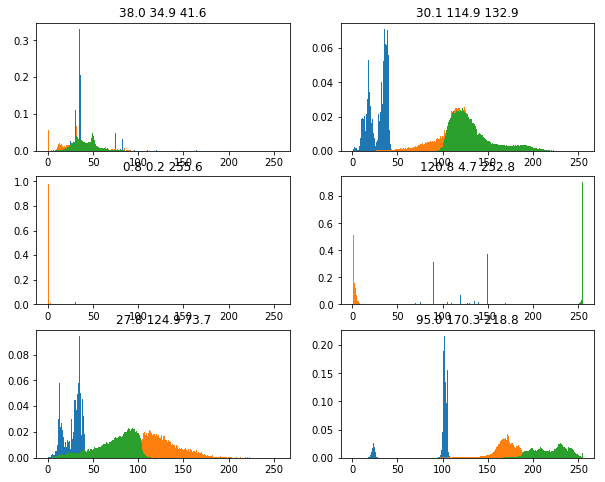

In [41]:
# For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255]
for i, (h, c) in enumerate(zip([A,B,C,D,E,F], center)):
    plt.subplot(3,2,i+1)
    # rgb
#     plt.hist(h[:,0],256,[0,255], normed=True)
#     plt.hist(h[:,1],256,[0,255], normed=True)
#     plt.hist(h[:,2],256,[0,255], normed=True)
    # hsv
    plt.hist(h[:,0],180,[0,179], normed=True)
    plt.hist(h[:,1],256,[0,255], normed=True)
    plt.hist(h[:,2],256,[0,255], normed=True)
    plt.title('{:.1f} {:.1f} {:.1f}'.format(*c))
                         
# plt.hist(B,256,[0,256], normed=True)
# plt.hist(C,256,[0,256], normed=True)
# plt.hist(D,256,[0,256], normed=True)
# # plt.hist(E,256,[0,256], normed=True)
# plt.hist(F,256,[0,256], normed=True)
plt.show();

In [27]:
center[0]

array([  28.22638702,  124.87297821,   78.02161407], dtype=float32)

Let's try another way. RBG is not a linear space and colors that are similar in appearance are not always next to each other. By switching to HSV, we are now in a cylindrical colorspace where colors are continous.

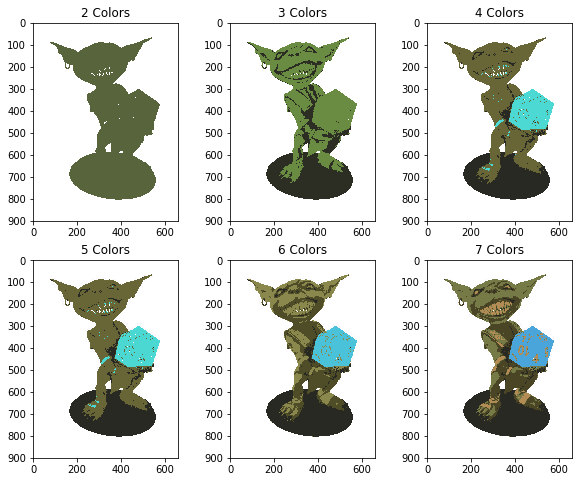

In [7]:
def quantize(img, K):
    # reshape (width, height, colors) to (width*height, colors)
    # the image is just a long array of pixels now
    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    return res2

img = cv2.imread('dnd.jpg')
# convert to a linear color space
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

for k in range(2,8):
    qimg = quantize(img, k)
    plt.subplot(2, 3, k-1)
    qimg = cv2.cvtColor(qimg, cv2.COLOR_HSV2RGB)
    plt.imshow(qimg)
    plt.title('{} Colors'.format(k))

In [19]:
# what does the reshape do?
a = np.zeros((10,10,3))
print(a.shape)
b = a.reshape((-1,3))
print(b.shape)
print(a.flatten().shape)

# now we have 3 color planes but we put all pixels
# in a row that we can sort/operate on

(10L, 10L, 3L)
(100L, 3L)
(300L,)
